# 参考程序
<font size=4>该程序来源于https://zhuanlan.zhihu.com/p/33733586<br>
使用最新的sklearn库</font>

# 1.导入依赖包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 2.导入数据

In [2]:
train = pd.read_csv('../data/train.csv',dtype={"Age": np.float64})
test = pd.read_csv('../data/test.csv',dtype={"Age": np.float64})
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)
train.info()
print('*'*10)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non

# 3.数据可视化

Percentage of females who survived:74.20
Percentage of males who survived:18.89


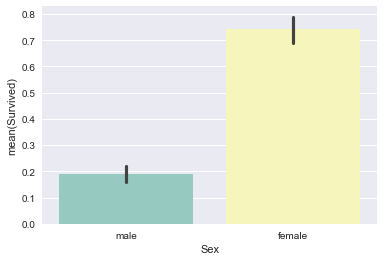

In [3]:
#性别特征
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
print("Percentage of females who survived:%.2f" % (train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100))
print("Percentage of males who survived:%.2f" % (train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100))

Percentage of Pclass = 1 who survived:62.96
Percentage of Pclass = 2 who survived:47.28
Percentage of Pclass = 3 who survived:24.24


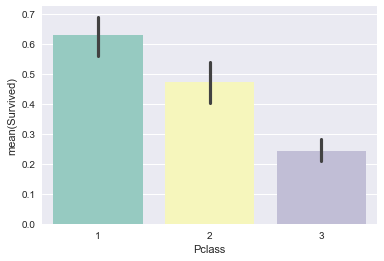

In [4]:
#乘客社会等级
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100))

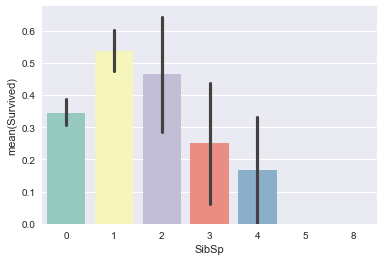

In [5]:
#配偶以及兄弟姐妹数
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')

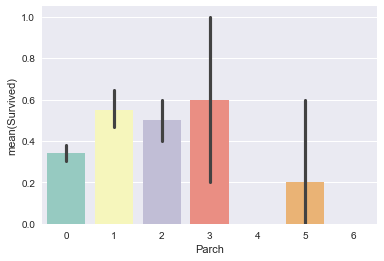

In [6]:
#父母和子女数
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')

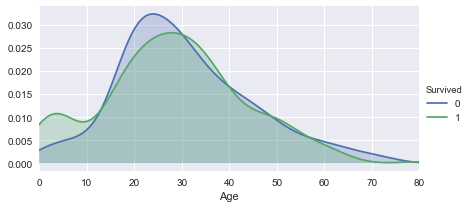

In [7]:
#年龄分布和生存下来的关系    kdeplot核密度分布图
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

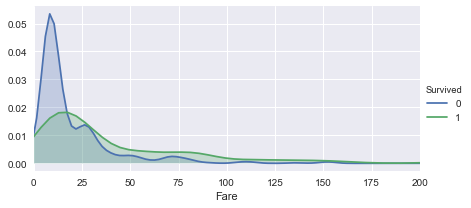

In [8]:
#船费和生存下来的关系
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()

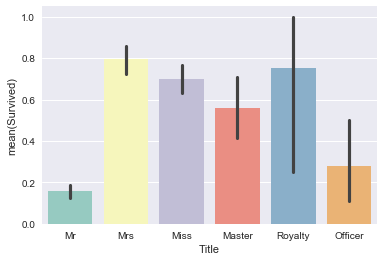

In [9]:
#姓名中的称呼和生存下来的关系
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

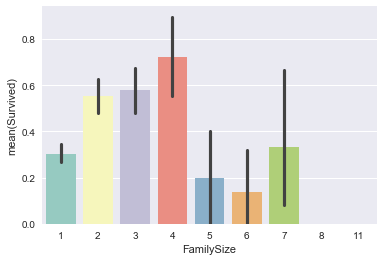

In [10]:
#将SibSp和Parch两个参数汇总，家庭成员和生存下来的关系
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

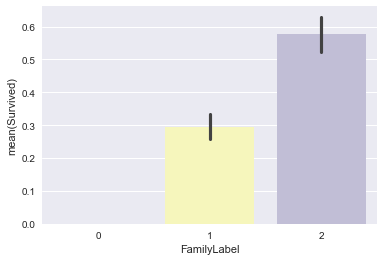

In [11]:
#将家庭成员分为三类
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

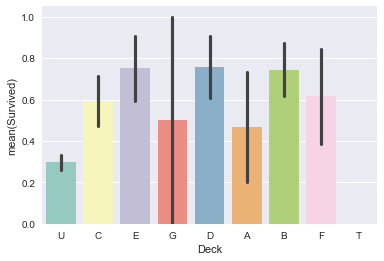

In [12]:
#不同船舱与生存下来的关系，
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')     #使用Unknown填充缺失值
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')
#all_data['Cabin']

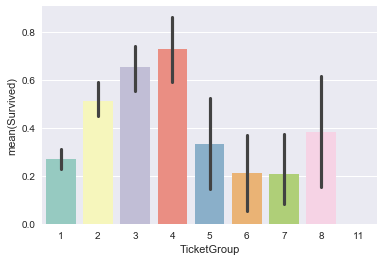

In [13]:
#船票有一样的，设置团队票与生存下来的关系
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

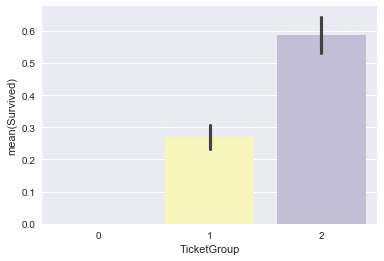

In [14]:
#将团队生存设置等级
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

# 4.数据清洗

In [15]:
#使用随机森林回归填充Age缺失值
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [16]:
#查看登录港口缺失值
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


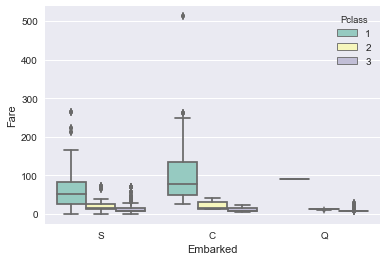

In [17]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass",data=all_data, palette="Set3")

In [18]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [19]:
#查看费用缺失值
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [20]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [21]:
#将姓氏相同的化为一组，分别提取出每组中的妇女，儿童和成年男性
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [22]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


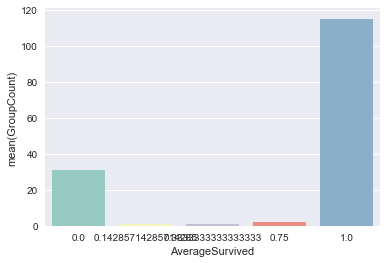

In [23]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"], palette='Set3').set_xlabel('AverageSurvived')

In [24]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


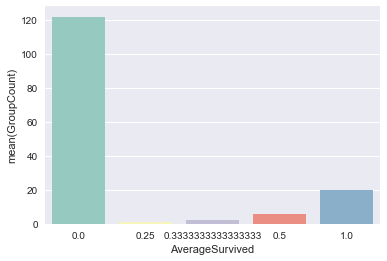

In [25]:
sns.barplot(x=Male_Adult.index, y=Male_Adult['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [26]:
#普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理
#把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Bourke', 'Palsson', 'Strom', 'Olsson', 'Lobb', 'Rosblom', 'Attalah', 'Lahtinen', 'Caram', 'Panula', 'Ilmakangas', 'Jussila', 'Zabour', 'Barbara', 'Goodwin', 'Sage', 'Turpin', 'Rice', 'Oreskovic', 'Skoog', 'Danbom', 'Van Impe', 'Robins', 'Lefebre', 'Vander Planke', 'Boulos', 'Johnston', 'Arnold-Franchi', 'Cacic', 'Ford', 'Canavan'}
{'Taylor', 'Goldenberg', 'Kimball', 'Jussila', 'Bradley', 'Beckwith', 'Bishop', 'Jonsson', 'Frolicher-Stehli', 'Daly', 'Chambers', 'Beane', 'Dick', 'Frauenthal', 'Nakid', 'McCoy', 'Cardeza', 'Duff Gordon', 'Greenfield', 'Harder'}


In [27]:
#对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [28]:
#特征转换，选取特征，转换为数值变量
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

# 5.建模和优化

In [29]:
#参数优化
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8810963508395343


In [30]:
#训练模型
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x0000000010B1C268>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1...estimators=26, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=True))])

In [31]:
#交叉验证
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8451402 | Std - 0.03276752 


# 6.预测

In [32]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("../out/submission.csv", index=False)